## Etivity 5: Feature Selection 

## Name: Brian Parle
## ID: 18200036

### Import Python modules

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing #needed for scaling attributes to the interval [0,1]

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

# Task1
## Wine Quality Experiment - First, take a single pass at creating models.
### A. Preparation

### Load and prepare the dataset for training and evaluation

In [174]:
wine_df = pd.read_csv("./winequality_red.csv")
wine_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


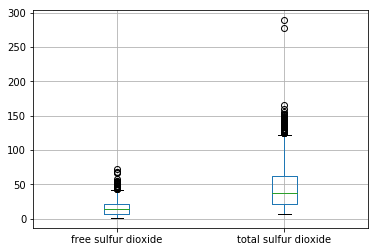

In [175]:
#a couple of the features have significant outliers - may look at those later to see if it helps model accuracy
wine_df.boxplot(column=['free sulfur dioxide','total sulfur dioxide'])

In [86]:
# target attribute
target_attribute_name = 'quality'
target = wine_df[target_attribute_name]

# predictor attributes
predictors = wine_df.drop(target_attribute_name, axis=1).values

# scale all predictor values to the range [0, 1]
# note the target attribute is already binary
min_max_scaler = preprocessing.MinMaxScaler()
predictors = min_max_scaler.fit_transform(predictors)

Split the data set into a training (80%) and test (20%) data sets.

In [96]:
# pepare independent stratified data sets for training and test of the final model
predictors_train, predictors_test, target_train, target_test = train_test_split(
    predictors, target, test_size=0.20, shuffle=True, stratify=target, random_state=39)

### B. Feature Selection

#### 1. Apply RFE with SVM for selecting the best features

In [97]:
# create a base classifier used to evaluate a subset of attributes
estimatorSVM = svm.SVR(kernel="linear")
selectorSVM = RFE(estimatorSVM, 3)
selectorSVM = selectorSVM.fit(predictors_train, target_train)
# summarize the selection of the attributes
print(selectorSVM.support_)
print(selectorSVM.ranking_)

[False  True False False False False False False False  True  True]
[5 1 9 4 2 7 3 6 8 1 1]


#### 2. Apply RFE with Logistic Regression for selecting the best features

In [98]:
# create a base classifier used to evaluate a subset of attributes
estimatorLR = LogisticRegression()
# create the RFE model and select 3 attributes
selectorLR = RFE(estimatorLR, 3)
selectorLR = selectorLR.fit(predictors_train, target_train)
# summarize the selection of the attributes
print(selectorLR.support_)
print(selectorLR.ranking_)

[False  True False False False False  True False False False  True]
[7 1 4 8 5 9 1 3 6 2 1]


### B. Evaluate on the Test Data Set

Apply the selectors to prepare training data sets only with the selected features

__Note:__ The same selectors are applied to the test data set. However, it is important that the test data set was not used by (it's invisible to) the selectors. 

In [99]:
predictors_train_SVMselected = selectorSVM.transform(predictors_train)
predictors_test_SVMselected = selectorSVM.transform(predictors_test)

In [100]:
predictors_train_LRselected = selectorLR.transform(predictors_train)
predictors_test_LRselected = selectorLR.transform(predictors_test)

### Train and evaluate SVM classifiers with both the selected features and all features 

Here we train three models:
* model1 - with the features selected by SVM
* model2 - with the features selected by Logistic Regression
* model3 - with all features (i.e. without feature selection)

In [101]:
classifier = svm.SVC()

In [102]:
model1 = classifier.fit(predictors_train_SVMselected, target_train)
m1_score = model1.score(predictors_test_SVMselected, target_test)
print(m1_score)

0.553125


In [103]:
model2 = classifier.fit(predictors_train_LRselected, target_train)
m2_score = model2.score(predictors_test_LRselected, target_test)
print(m2_score)

0.5625


In [104]:
model3 = classifier.fit(predictors_train, target_train)
m3_score = model3.score(predictors_test, target_test)
print(m3_score)

0.553125


### C. Initial Conclusion

From the results above, model2 is most accurate. However, at 56.25% accuracy it is very poor.

# Task2
## Wine Quality Experiment - Run in a loop
### Preparation

In [105]:
# target attribute
target_attribute_name = 'quality'
target = wine_df[target_attribute_name]

# predictor attributes
predictors = wine_df.drop(target_attribute_name, axis=1).values

# scale all predictor values to the range [0, 1]
# note the target attribute is already binary
min_max_scaler = preprocessing.MinMaxScaler()
predictors = min_max_scaler.fit_transform(predictors)

### LOOP

#### 1. Apply RFE with SVM for selecting the best features

In [137]:
k=10
model_scores = []
#Loop k times, select a train/test split from the full dataset, perform RFE/SVM and RFE/LR and then score 3 SVM models
for i in range(0, k):
    #select stratified train/test datasets
    #set random_state so that it starts at 39 and loops back to 39 for the last run (see summary comments below)
    predictors_train, predictors_test, target_train, target_test = train_test_split(
    predictors, target, test_size=0.20, shuffle=True, stratify=target, random_state=39+(i%(k-1)))
    
    #Apply RFE with SVM for selecting the best features
    # create a base classifier used to evaluate a subset of attributes
    estimatorSVM = svm.SVR(kernel="linear")
    selectorSVM = RFE(estimatorSVM, 3)
    selectorSVM = selectorSVM.fit(predictors_train, target_train)
    
    #Apply RFE with Logistic Regression for selecting the best features
    # create a base classifier used to evaluate a subset of attributes
    estimatorLR = LogisticRegression()
    selectorLR = RFE(estimatorLR, 3)
    selectorLR = selectorLR.fit(predictors_train, target_train) 

    #Evaluate on the Test Data Set
    #Apply the selectors to prepare training data sets only with the selected features
    predictors_train_SVMselected = selectorSVM.transform(predictors_train)
    predictors_test_SVMselected = selectorSVM.transform(predictors_test)
    
    predictors_train_LRselected = selectorLR.transform(predictors_train)
    predictors_test_LRselected = selectorLR.transform(predictors_test)
    
    #Train and evaluate three models:
    #model1 - with the features selected by SVM
    #model2 - with the features selected by Logistic Regression
    #model3 - with all features (i.e. without feature selection)
    classifier = svm.SVC()
    model1 = classifier.fit(predictors_train_SVMselected, target_train)
    score1 = model1.score(predictors_test_SVMselected, target_test)

    model2 = classifier.fit(predictors_train_LRselected, target_train)
    score2 = model2.score(predictors_test_LRselected, target_test)

    model3 = classifier.fit(predictors_train, target_train)
    score3 = model3.score(predictors_test, target_test)

    model_scores.append([i, score1, score2, score3])


39
40
41
42
43
44
45
46
47
39


   run    model1    model2    model3
0    0  0.553125  0.562500  0.553125
1    1  0.521875  0.528125  0.528125
2    2  0.581250  0.581250  0.590625
3    3  0.559375  0.556250  0.559375
4    4  0.593750  0.593750  0.593750
5    5  0.553125  0.568750  0.568750
6    6  0.550000  0.556250  0.537500
7    7  0.553125  0.565625  0.543750
8    8  0.565625  0.553125  0.562500
9    9  0.553125  0.562500  0.553125


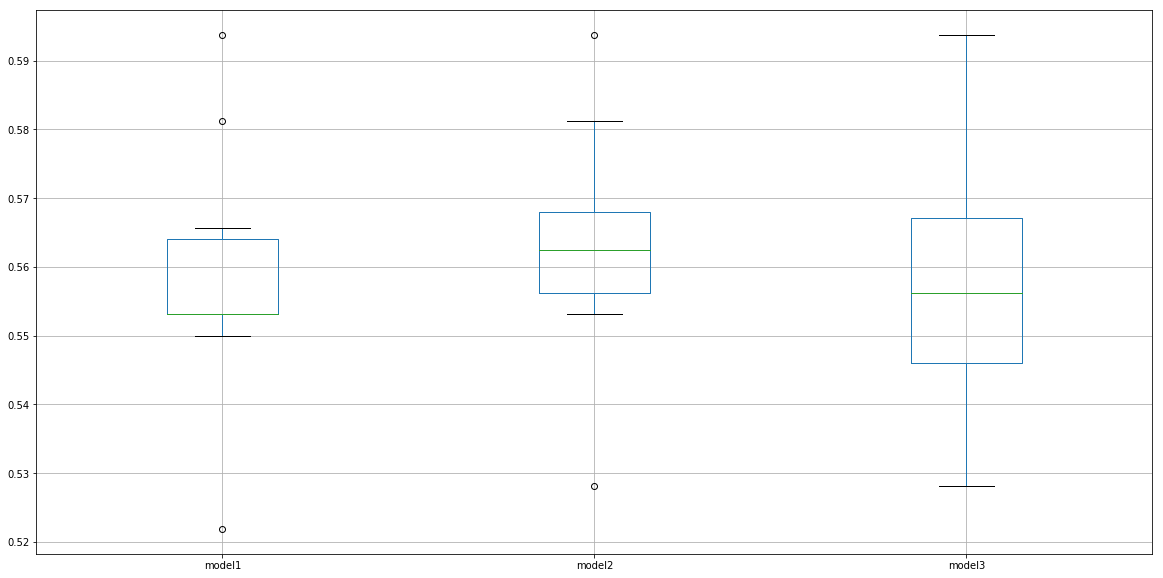

In [145]:
scores_df = pd.DataFrame(model_scores, columns = ['run','model1','model2','model3'])
print(scores_df)
scores_df.boxplot(column=['model1','model2','model3'], figsize=(20,10))

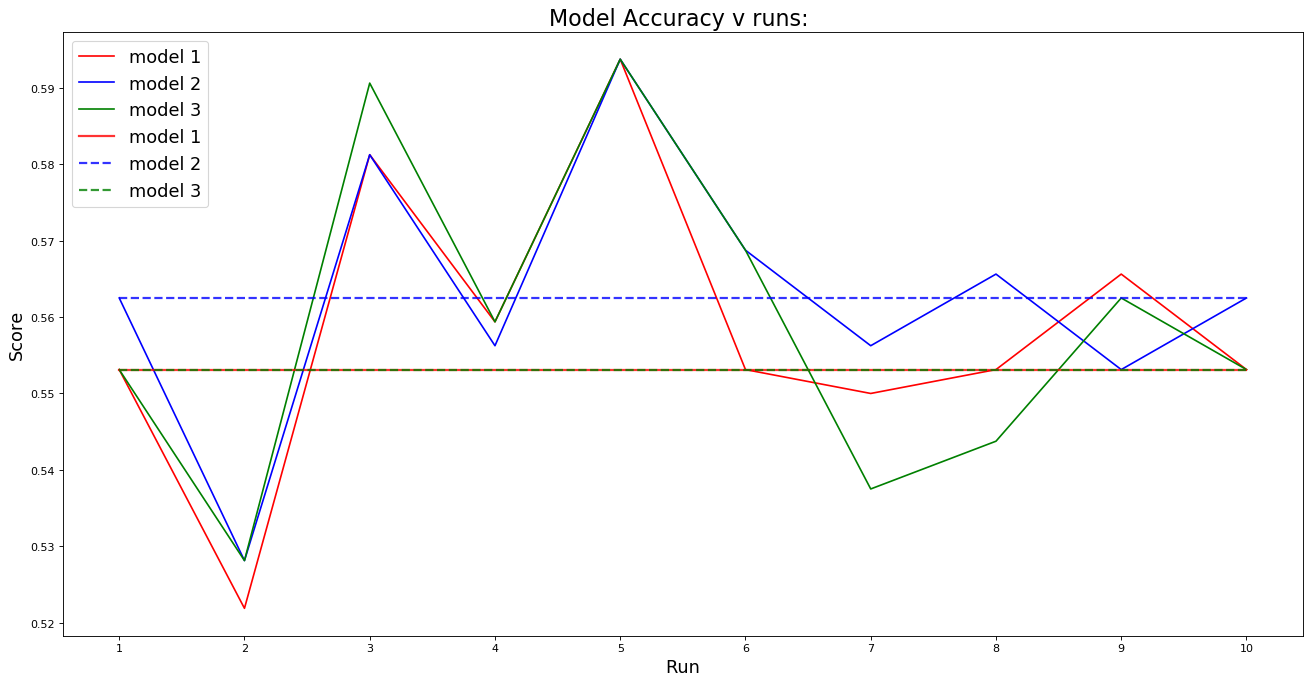

In [147]:
#do a more detailed plot the model scores for each iteration
plt.figure(figsize=(20,10), dpi=80)

plt.plot(scores_df['run']+1, scores_df['model1'], 'r', label='model 1')
plt.plot(scores_df['run']+1, scores_df['model2'], 'b', label='model 2')
plt.plot(scores_df['run']+1, scores_df['model3'], 'g', label='model 3')
#plot lines for the model scores from Task 1
plt.plot([1, k], [m1_score, m1_score], linestyle='-', lw=2, color='r', label='model 1', alpha=.8)
plt.plot([1, k], [m2_score, m2_score], linestyle='--', lw=2, color='b', label='model 2', alpha=.8)
plt.plot([1, k], [m3_score, m3_score], linestyle='--', lw=2, color='g', label='model 3', alpha=.8)

plt.xlabel('Run', fontsize=16)
plt.xticks(scores_df['run']+1)
plt.ylabel('Score', fontsize=16)
plt.title('Model Accuracy v runs: ', fontsize=20)
plt.legend(loc="upper left", fontsize=16)
plt.show()

### Task 2. Comment

The boxplot shows that the average accuracy across k runs is similar to the accuracy from Task 1. 

On average, model 2 performs better. Model 1 has a smaller variance over the q1-q3 quartiles. Model 3 has the largest variance in performance. The overall best performance is 59.375% in the fifth iteration. The least accurate modle was model 1 in the second run, giving an accuracy of 55.3125%. The second chart shows that the performance is sensitive to the train and test data sets. Choosing a different random state for the test_train_split has generated different splits yielding different results. Running the lasp loop with the same random_state as the first, has yielded the same results as loop 0, and the Task 1 model.

## Task 3. Build 2 pipelines

In [169]:
# Inspiration taken from implementations here:
# 1.
# Description: https://towardsdatascience.com/a-simple-example-of-pipeline-in-machine-learning-with-scikit-learn-e726ffbb6976
# Code: https://github.com/suvoooo/Machine_Learning/blob/master/pipelineWine.py
# 2.
# https://machinelearningmastery.com/automate-machine-learning-workflows-pipelines-python-scikit-learn/
# 3.
# https://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/

#reset the predictors to the unscaled values from the origional dataset
predictors = wine_df.drop(target_attribute_name, axis=1).values

# Pipeline 1. 
# Preprocessing: Use MinMaxScaling to scale predictor values in the range [0,1]
# Feature Selection: Use PCA to select top 3 components
steps = [('scaler', preprocessing.MinMaxScaler()), ('pca', PCA(n_components=3)), ('logistic', LogisticRegression())]
pipeline = Pipeline(steps)
# create train and test sets
X_train, X_test, y_train, y_test = train_test_split(predictors,target,test_size=0.2, random_state=39, stratify=target)
kfold = KFold(n_splits=5, random_state=39)
results = cross_val_score(pipeline, X_test, y_test, cv=kfold)
print("score = %3.4f" %(results.mean()))

score = 0.5375
0.5375


In [173]:
# Pipeline 2
# Preprocessing: Use MinMaxScaling to scale predictor values in the range [0,1]
# Feature Selection: Use RFE to select top 3 components
rfe_model = svm.SVR(kernel="linear")
steps = [('scaler', preprocessing.MinMaxScaler()), ('rfe', RFE(rfe_model, 3)), ('SVM', svm.SVC())]
pipeline = Pipeline(steps)
# create the hyperparameter options
parameteres = {'SVM__C':[0.001,0.1,10,100,10e5], 'SVM__gamma':[0.1,0.01]}
# create train and test sets
X_train, X_test, y_train, y_test = train_test_split(predictors,target,test_size=0.2, random_state=7, stratify=target)

# Grid Search Cross Validation
grid = GridSearchCV(pipeline, param_grid=parameteres, cv=5)
grid.fit(X_train, y_train)

print("score = %3.4f" %(grid.score(X_test,y_test)))
print(grid.best_params_)


score = 0.6188
{'SVM__C': 1000000.0, 'SVM__gamma': 0.01}


### Task 3. Comment

The first pipeline combined a preprocessing step with PCA to select the top 3 features and a LogisticRegression model. I used cross validation to evaluate the models with 5 folds. The model accuracy was 53.75%

The second pipeline combined a minmaxscaler preprocessing step with RFE (on SVM) for feature selection and a finsl SVM (SVC) model - similar to model 1 in task 1. The hyperparameters were tuned using a 5-fold Cross Validating Grid Search.

The RFE/SVM pipeline produced a better performing model with a final accuracy of 61.88%